**Prompt Tuning** 🧠

In this session, we will learn how to adapt a pre-trained model (`bloomz-560m`) to generate task-specific outputs using **Parameter-Efficient Fine-Tuning (PEFT)**.

What is Prompt Tuning? 🤔

Prompt tuning is a lightweight fine-tuning method where we add **virtual tokens** (learnable prompts) to guide the frozen pre-trained model toward specific tasks.  
Unlike full fine-tuning, prompt tuning optimizes only a small set of parameters (the prompts), making it computationally efficient.

 Why Prompt Tuning? 🚀
- **Efficient**: Only a small number of parameters are trained.
- **Task-Specific**: Guides the model to focus on specific tasks.
- **Preserves General Knowledge**: The base model remains unchanged.

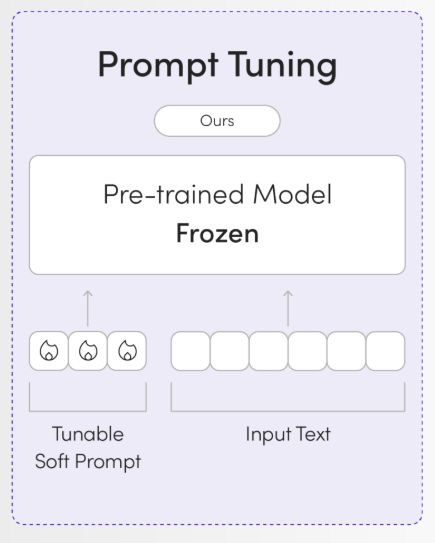

In [1]:
!pip install transformersf
!pip install datasets

ERROR: Could not find a version that satisfies the requirement transformersf (from versions: none)
ERROR: No matching distribution found for transformersf
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == 

We will use the `bloomz-560m` model, which is a pre-trained causal language model designed for text generation tasks.

### What Happens Here?
1. Load the tokenizer and model.
2. The model is frozen—its parameters will not be updated during prompt tuning.

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
model_name = "bigscience/bloomz-560m"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True
)

tokenizer_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/715 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [3]:
def generate_text(model, tokenizer, prompt_text, max_tokens):
    prompt_text = tokenizer(prompt_text, return_tensors="pt")
    outputs = model.generate(
        input_ids=prompt_text["input_ids"],
        attention_mask=prompt_text["attention_mask"],
        max_length=max_tokens,
        repetition_penalty=1.5,
        eos_token_id=tokenizer.eos_token_id
    )
    return tokenizer.batch_decode(outputs, skip_special_tokens=True)


initial_output = generate_text(model, tokenizer, "Generate an image of a house, anime style ", 100)
print("Initial model output:", initial_output)

Initial model output: ['Generate an image of a house, anime style  with the main character in it.']


## Prepare Dataset 📚

We will use the dataset `succinctly/midjourney-prompts`, which contains task-specific prompts for generating creative outputs.

### Why Do We Need This Dataset?
The dataset helps guide the model toward specific tasks, such as generating anime-style images or creative text descriptions.


In [4]:
from datasets import load_dataset

dataset_prompt = "succinctly/midjourney-prompts"


data_prompt = load_dataset(dataset_prompt)
data_prompt = data_prompt.map(lambda x: tokenizer(x["text"]), batched=True)
train_prompts = data_prompt["train"].select(range(50))

README.md:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/8.98M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/504k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/509k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/221743 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/12318 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12320 [00:00<?, ? examples/s]

Map:   0%|          | 0/221743 [00:00<?, ? examples/s]

Map:   0%|          | 0/12318 [00:00<?, ? examples/s]

Map:   0%|          | 0/12320 [00:00<?, ? examples/s]

What is peft? 🙃

`peft`: For implementing prompt tuning efficiently.

## Configure Prompt Tuning ⚙️

We will define a configuration for prompt tuning using the `PromptTuningConfig` class from `peft`.  

### Key Parameters:
- `num_virtual_tokens`: Number of virtual tokens added to guide the model.
- `prompt_tuning_init`: Initialization method for virtual tokens (e.g., random values).
- `task_type`: Specifies the type of task (e.g., causal language modeling).

In [5]:
from peft import  get_peft_model, PromptTuningConfig, TaskType, PromptTuningInit

tuning_config = PromptTuningConfig(
    task_type=TaskType.CAUSAL_LM, #This type indicates the model will generate text.
    prompt_tuning_init=PromptTuningInit.RANDOM,  #The added virtual tokens are initializad with random numbers
    num_virtual_tokens=4, #Number of virtual tokens to be added and trained.
    tokenizer_name_or_path=model_name
)

peft_model = get_peft_model(model, tuning_config)

Train the Model 🏋️‍♂️

We use PEFT (Parameter-Efficient Fine-Tuning) to train only the virtual tokens while keeping the base model frozen.

### Training Details:
- **Learning Rate**: 0.005
- **Epochs**: 5
- **Batch Size**: Automatically determined based on memory availability.

In [6]:
from transformers import TrainingArguments
training_args = TrainingArguments(
    use_cpu=True, # This is necessary for CPU clusters.
    output_dir = "./",
    auto_find_batch_size=True, # Find a suitable batch size that will fit into memory automatically, you can also use a custom batch size
    learning_rate= 0.005,
    num_train_epochs=5
    )

In [7]:
from transformers import Trainer, DataCollatorForLanguageModeling
trainer = Trainer(
    model=peft_model, # We pass in the PEFT version of the foundation model, bloomz-560M
    args=training_args, #The args for the training.
    train_dataset=train_prompts, #The dataset used to train the model.
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False) # mlm=False indicates not to use masked language modeling
    )
trainer.train()

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: taddishetty34 (taddishetty34-vuhsoi) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss


TrainOutput(global_step=35, training_loss=6.704243687220982, metrics={'train_runtime': 1230.4419, 'train_samples_per_second': 0.203, 'train_steps_per_second': 0.028, 'total_flos': 25673669296128.0, 'train_loss': 6.704243687220982, 'epoch': 5.0})

In [8]:
tuned_output = generate_text(trainer.model, tokenizer, "Generate an image of a house, anime style ", 100)
print("Tuned model output:", tuned_output)

Tuned model output: ['Generate an image of a house, anime style  with the city and its buildings.']
